# Predicting Perceived Importance of Mental Health

## Gathering Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split

# Read sqlite query results into a pandas DataFrame
# Collecting 2016-2019 data
con = sqlite3.connect("mental_health.sqlite")
survey = pd.read_sql_query("SELECT * from survey", con, dtype='str')
question = pd.read_sql_query("SELECT * from question", con, dtype='str')
answer = pd.read_sql_query("SELECT * from answer", con, dtype='str')

#Adding a what year is it question
question = question.append({'questionid':'0', 'questiontext':'year'}, ignore_index=True)

print(answer.head())

con.close()

  AnswerText SurveyID UserID QuestionID
0         37     2014      1          1
1         44     2014      2          1
2         32     2014      3          1
3         31     2014      4          1
4         31     2014      5          1


In [2]:
answer = answer.rename(columns={'QuestionID':'questionid'})
# Adding a year to each of the repondants answers
for userId in answer.UserID.unique():
    row = answer[answer.UserID == userId].iloc[0]
    s = pd.Series({'AnswerText':row.SurveyID, 'SurveyID':row.SurveyID, 'UserID':row.UserID, 'questionid':'0'})
#     info = np.array([[row.SurveyID],[row.SurveyID],[row.UserID],[0]])
    
#     col = ['AnswerText', 'SurveyID', 'UserID', 'questionid']
#     df = pd.DataFrame(data = info, columns=col)
    answer = answer.append(s, ignore_index=True)

In [3]:
# Add the what questions each response is answering
q_and_a = answer.join(question.set_index('questionid'), on="questionid", how='inner')
q_and_a

,AnswerText,SurveyID,UserID,questionid,questiontext
0,37,2014,1,1,What is your age?
1,44,2014,2,1,What is your age?
2,32,2014,3,1,What is your age?
3,31,2014,4,1,What is your age?
4,31,2014,5,1,What is your age?
...,...,...,...,...,...
241111,2019,2019,4214,0,year
241112,2019,2019,4215,0,year
241113,2019,2019,4216,0,year
241114,2019,2019,4217,0,year


## Data Preprocessing

In [4]:
# Turn data from long format to wide
q_and_a_pivot = q_and_a.pivot_table(values='AnswerText', index='UserID', columns='questiontext', aggfunc=', '.join)
re_q_and_a = q_and_a_pivot.reindex(columns=question.questiontext)

# Get empolyees who answered questions after 2017
past_2017 = re_q_and_a[(re_q_and_a.year.astype(int) >= 2017) & (re_q_and_a['Are you self-employed?'] == '0')]

print(past_2017.shape)

# Get 2020 data
survey2020 = pd.read_csv('OSMI 2020 Mental Health in Tech Survey Results .csv',dtype='str').fillna('-1')
survey2020['year'] = '2020'
survey2020.columns = survey2020.columns.str.replace('*', '')
survey2020 = survey2020[(survey2020['Are you self-employed?'] == '0')]
survey2020 = survey2020.rename(columns={'Would you bring up your mental health with a potential employer in an interview?':'Would you bring up a mental health issue with a potential employer in an interview?',
                           'Have you observed or experienced a supportive or well handled response to a mental health issue in your current or previous workplace?':'Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?',
                           'Have your observations of how another individual who discussed a mental health issue made you less likely to reveal a mental health issue yourself in your current workplace?':'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?',
                           'If you have a mental health disorder, how often do you feel that it interferes with your work when _NOT_ being treated effectively (i.e., when you are experiencing symptoms)?':'If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?'
                          })
# with pd.option_context('display.max_seq_items', None):
#     print(survey2020.columns)
print(survey2020.shape)

#Combine to have data from 2017 to 2020
not_null = pd.concat([past_2017, survey2020],join='inner',ignore_index=True)

percent_missing = not_null.isnull().sum() * 100 / len(not_null)

missing_value_df = pd.DataFrame({'column_name': not_null.columns,
                                 'percent_missing': percent_missing})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(missing_value_df)

# Drop colmuns with nans
not_null = not_null.dropna(axis=1)

# Drop self employed questions
not_null = not_null.drop(['Are you self-employed?'],axis=1)
display(not_null.shape)

(1308, 106)
(155, 121)


<ipython-input-4-dad97e516463>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  survey2020['year'] = '2020'
<ipython-input-4-dad97e516463>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  survey2020.columns = survey2020.columns.str.replace('*', '')


,column_name,percent_missing
What is your age?,What is your age?,0.0
What is your gender?,What is your gender?,0.0
What country do you live in?,What country do you live in?,0.0
Are you self-employed?,Are you self-employed?,0.0
Do you have a family history of mental illness?,Do you have a family history of mental illness?,0.0
Have you ever sought treatment for a mental health disorder from a mental health professional?,Have you ever sought treatment for a mental he...,0.0
How many employees does your company or organization have?,How many employees does your company or organi...,0.0
Is your employer primarily a tech company/organization?,Is your employer primarily a tech company/orga...,0.0
Does your employer provide mental health benefits as part of healthcare coverage?,Does your employer provide mental health benef...,0.0
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,Is your anonymity protected if you choose to t...,0.0


(1463, 75)

In [5]:
#Shorten names
not_null = not_null.rename(columns={'How many employees does your company or organization have?': 'orgSize', \
        'Is your employer primarily a tech company/organization?':'isTech', \
        'Is your primary role within your company related to tech/IT?':'isRoleTech', \
        'Does your employer provide mental health benefits as part of healthcare coverage?':'mentalHealthCoverage', \
        'Do you know the options for mental health care available under your employer-provided health coverage?':'knowledgeOfCareOptions', \
        'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?':'employerDiscussMH', \
        'Does your employer offer resources to learn more about mental health disorders and options for seeking help?':'resourcesOffered', \
        'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?':'anonymity', \
        'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?':'askingForLeave', \
        'Would you feel comfortable discussing a mental health issue with your coworkers?':'MHwithCoworkers',
        'Have you ever discussed your mental health with coworkers?':'discussedCoworkers',
        'Have you ever had a coworker discuss their or another coworker\'s mental health with you?':'anotherCoworker',
        'Would you feel more comfortable talking to your coworkers about your physical health or your mental health?':'coworkersMHvsPH',
        'Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?': 'MHwithSupervisor',
        'Have you ever discussed your mental health with your employer?': 'discussedSupervisor',
        'Overall, how much importance does your employer place on physical health?': 'PHImportance',
        'Overall, how much importance does your employer place on mental health?': 'MHImportance',
        
        'Do you have previous employers?':'prevEmployer',\
        'Was your employer primarily a tech company/organization?':'prevTech',
        'Have your previous employers provided mental health benefits?':'prevMHBenefits',\
        'Were you aware of the options for mental health care provided by your previous employers?':'prevAwareBenefits',\
        'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?':'prevDiscussMH',\
        'Did your previous employers provide resources to learn more about mental health disorders and how to seek help?':'prevResources',\
        'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?':'prevAnonymity',\
        'Did you ever discuss your mental health with a previous coworker(s)?':'prevDiscussedCoworkers',
        'Did you ever have a previous coworker discuss their or another coworker\'s mental health with you?':'prevAnotherCoworker',
        'Did you ever discuss your mental health with your previous employer?':'prevEmployerDiscuss',
        'Would you have been willing to discuss your mental health with your direct supervisor(s)?':'prevDiscussSupervisor',\
        'Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?':'prevEmployerMHvsPH',
        'Overall, how much importance did your previous employer place on physical health?':'prevPH',
        'Overall, how much importance did your previous employer place on mental health?':'prevMH',
                                    
        'Would you be willing to bring up a physical health issue with a potential employer in an interview?':'interviewMentionPH',\
        'Would you bring up a mental health issue with a potential employer in an interview?':'interviewMentionMH',\
        'Are you openly identified at work as a person with a mental health issue?':'openMH',
        'Has being identified as a person with a mental health issue affected your career?':'careerMHstigma',
        'If they knew you suffered from a mental health disorder, how do you think that your team members/co-workers would react?':'coworkersMHstigma',\
        'How willing would you be to share with friends and family that you have a mental illness?':'familyMHstigma',\
        'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?':'observedBadMHResp',
        'Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?':'observedGoodMHResp',\
        'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?':'observedOthersDeter',\
        
        'Do you have a family history of mental illness?':'familyHistory',\
        'Have you had a mental health disorder in the past?':'pastDisorder',\
        'Do you currently have a mental health disorder?':'currentDisorder',\
        'Have you ever been diagnosed with a mental health disorder?':'diagnosis',\
        'Have you ever sought treatment for a mental health disorder from a mental health professional?':'soughtMHTreatment',\
        'If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?':'affectWorkWithTreatment',\
        'If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?':'affectWorkNoTreatment',\
        
        'What is your age?':'age',\
        'What is your race?':'race',
        'What is your gender?':'gender',\
        'What country do you live in?':'countryLive',\
        'If you live in the United States, which state or territory do you live in?':'stateLive',\
        'What country do you work in?':'countryWork',\
        'What US state or territory do you work in?':'stateWork',\
#         'Which of the following best describes your work position?':'workPosition',\
        'Overall, how well do you think the tech industry supports employees with mental health issues?':'techSupport',
        #'Do you work remotely?':'workRemote'
                                        }) 

with pd.option_context('display.max_columns', None):
    display(not_null.sample(50))

,age,gender,countryLive,familyHistory,soughtMHTreatment,orgSize,isTech,mentalHealthCoverage,anonymity,interviewMentionMH,isRoleTech,knowledgeOfCareOptions,employerDiscussMH,resourcesOffered,askingForLeave,MHwithCoworkers,MHwithSupervisor,Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?,Do you know local or online resources to seek help for a mental health issue?,prevEmployer,prevMHBenefits,prevAwareBenefits,prevDiscussMH,prevResources,prevAnonymity,prevDiscussSupervisor,interviewMentionPH,familyMHstigma,observedOthersDeter,pastDisorder,currentDisorder,diagnosis,affectWorkWithTreatment,affectWorkNoTreatment,countryWork,stateWork,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",observedBadMHResp,coworkersMHvsPH,discussedSupervisor,"Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.",discussedCoworkers,Describe the conversation with coworkers you had about your mental health including their reactions.,anotherCoworker,Describe the conversation your coworker had with you about their mental health (please do not use names).,PHImportance,MHImportance,"If you have revealed a mental health disorder to a client or business contact, how has this affected you or the relationship?","If you have revealed a mental health disorder to a coworker or employee, how has this impacted you or the relationship?",prevTech,prevEmployerMHvsPH,prevEmployerDiscuss,"Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",prevDiscussedCoworkers,Describe the conversation you had with your previous coworkers about your mental health including their reactions.,prevAnotherCoworker,Describe the conversation your coworker had with you about their mental health (please do not use names)..1,prevPH,prevMH,openMH,careerMHstigma,How has it affected your career?,coworkersMHstigma,Describe the circumstances of the badly handled or unsupportive response.,observedGoodMHResp,Describe the circumstances of the supportive or well handled response.,techSupport,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,"If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.",Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used _anonymously_ and only with your permission.),race,year
152,37,Male,United States of America,No,0,26-100,1,Yes,Yes,Maybe,1,Yes,No,I don't know,Somewhat easy,Maybe,Yes,-1,-1,1,I don't know,N/A (was not aware),None did,None did,"Yes, always",Some of my previous supervisors,Maybe,Very open,No,No,No,-1,Not applicable to me,Not applicable to me,United States of America,Illinois,-1,-1,-1,-1,No,Same level of comfort for each,1,"After a particularly messy non-work situation,...",0,-1,0,-1,7,7,-1,-1,1,Physical health,1,"Years ago, after a messy breakup I was on a ra...",0,-1,0,-1,7,7,0,-1,-1,8,-1,Maybe/Not sure,-1,3,Forceably turn off people's computers after 40...,Having OSMI around and spreading its message m...,0,I prefer not to answer,2017
179,27,Female,Spain,No,0,26-100,1,No,No,No,1,No,No,No,Neither easy nor difficult,Yes,Yes,-1,-1,0,-1,-1,-1,-1,-1,-1,No,Very open,No,N

In [6]:
not_null = not_null[['orgSize','isTech','isRoleTech','mentalHealthCoverage','knowledgeOfCareOptions','employerDiscussMH',
                     'resourcesOffered','anonymity','askingForLeave','MHwithCoworkers','discussedCoworkers','anotherCoworker','coworkersMHvsPH',
                     'MHwithSupervisor','discussedSupervisor','PHImportance','MHImportance',
                     'interviewMentionPH','interviewMentionMH','openMH','careerMHstigma','coworkersMHstigma','familyMHstigma','observedBadMHResp','observedGoodMHResp','observedOthersDeter',
                     'familyHistory','pastDisorder','currentDisorder','diagnosis','soughtMHTreatment','affectWorkWithTreatment','affectWorkNoTreatment',
                     'age','race','gender', 'countryWork','techSupport']]
with pd.option_context('display.max_columns', None):
    display(not_null)

,orgSize,isTech,isRoleTech,mentalHealthCoverage,knowledgeOfCareOptions,employerDiscussMH,resourcesOffered,anonymity,askingForLeave,MHwithCoworkers,discussedCoworkers,anotherCoworker,coworkersMHvsPH,MHwithSupervisor,discussedSupervisor,PHImportance,MHImportance,interviewMentionPH,interviewMentionMH,openMH,careerMHstigma,coworkersMHstigma,familyMHstigma,observedBadMHResp,observedGoodMHResp,observedOthersDeter,familyHistory,pastDisorder,currentDisorder,diagnosis,soughtMHTreatment,affectWorkWithTreatment,affectWorkNoTreatment,age,race,gender,countryWork,techSupport
0,100-500,1,1,No,Yes,No,I don't know,I don't know,I don't know,Yes,1,1,Same level of comfort for each,Yes,0,6,0,Yes,No,0,-1,10,Neutral,"Yes, I experienced","Yes, I experienced",No,No,Possibly,Possibly,-1,1,Sometimes,Sometimes,27,-1,Female,United Kingdom,1
1,100-500,1,1,Yes,Yes,No,No,I don't know,I don't know,Yes,1,1,Same level of comfort for each,Maybe,0,7,2,Yes,No,0,-1,6,Somewhat not open,"Yes, I observed",Maybe/Not sure,No,No,Possibly,Possibly,-1,0,Not applicable to me,Sometimes,31,-1,male,United Kingdom,2
2,6-25,1,1,I don't know,No,I don't know,No,Yes,Difficult,Maybe,1,0,Same level of comfort for each,Yes,1,0,1,Maybe,No,1,1,5,Neutral,"Yes, I experienced","Yes, I experienced",Yes,Yes,Yes,Yes,Yes,1,Sometimes,Sometimes,36,White,male,United States of America,1
3,More than 1000,1,1,Yes,Yes,I don't know,I don't know,Yes,Difficult,Yes,1,0,Same level of comfort for each,Yes,1,7,5,No,No,0,-1,5,Very open,Maybe/Not sure,Maybe/Not sure,No,I don't know,No,Yes,Yes,1,Sometimes,Often,22,White,Male,United States of America,2
4,100-500,1,0,Yes,No,No,I don't know,Yes,Somewhat easy,Maybe,0,0,Physical health,Maybe,0,9,5,Maybe,No,0,-1,4,Neutral,"Yes, I observed","Yes, I observed",Maybe,Yes,No,No,-1,0,Rarely,Not applicable to me,30,White,male,United States of America,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,More than 1000,0,1,No,No,No,No,No,Somewhat difficult,No,0,0,Physical health,No,0,2,2,No,No,0,-1,1,9,No,No,No,No,No,No,-1,0,Sometimes,Often,53,Asian,Male,United States of America,2
1459,26-100,1,1,Yes,Yes,Yes,Yes,I don't know,Very easy,Maybe,1,0,Physical health,Maybe,0,9,7,Maybe,Maybe,0,-1,8,4,"Yes, I experienced",No,-1,No,Don't Know,Possibly,-1,0,Often,Often,23,-1,F,Philippines,3
1460,100-500,1,1,I don't know,No,No,I don't know,I don't know,Somewhat easy,Maybe,1,1,Physical health,Maybe,0,5,5,Maybe,No,0,-1,5,7,No,No,-1,Yes,Possibly,Yes,Yes,1,Sometimes,Often,34,White,Male,United States of America,3
1461,500-1000,0,1,Yes,No,Yes,Yes,Yes,Difficult,Maybe,0,1,Physical health,No,0,6,5,No,No,0,-1,2,5,"Yes, I observed",No,Maybe,Yes,Possibly,Possibly,-1,1,Rarely,Sometimes,43,-1,Male,Canada,3


Text(0.5, 1.0, 'Uncleaned Gender Frequency')

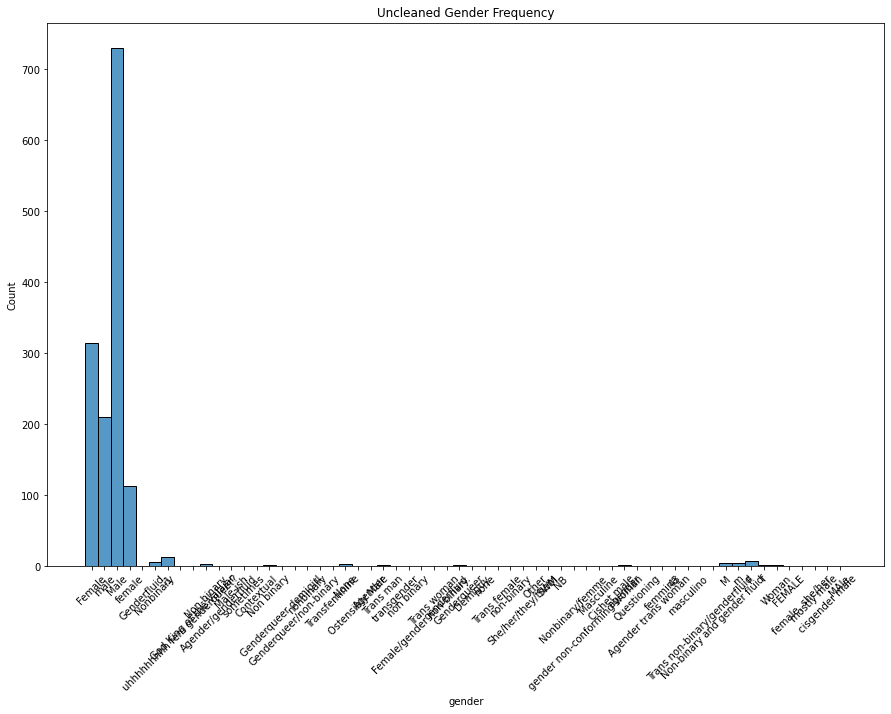

In [7]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=45)
sns.histplot(not_null.gender).set_title('Uncleaned Gender Frequency')

Text(0.5, 1.0, 'Uncleaned Age Frequency')

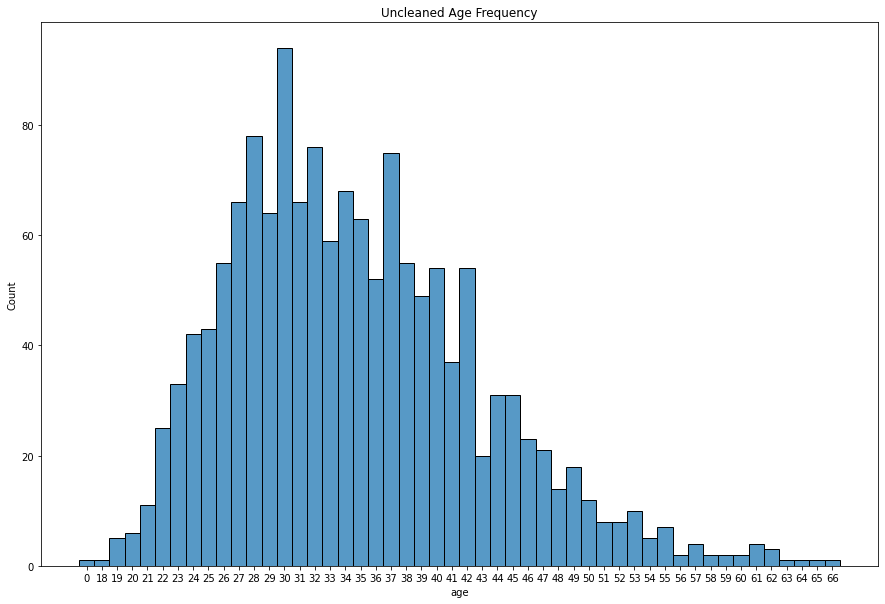

In [8]:
plt.figure(figsize=(15, 10))
sns.histplot(not_null.age.sort_values()).set_title('Uncleaned Age Frequency')

In [9]:
#Fix Gender
not_null.gender = not_null.gender.str.lower()
male = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", 
        "cis male",'dude','m|','cisdude',"i'm a man why didn't you make this a drop down question. you should of asked sex? and i would of answered yes please. seriously how much text can this take? ",
       'sex is male','male.', 'god king of the valajar', 'masculine', 'ostensibly male', 'swm', 'masculino', 'cishet male','mostly male', 'cisgender male']
female = ["cis female", "f", "female", " female","woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail",
         'female or multi-gender femme','cis female ','fem','cisgender female','female assigned at birth ','cis-woman',
         'i identify as female.','female/woman','fm','female assigned at birth', 'gender non-conforming woman','femmina',
         'she/her/they/them', 'female, she/her']
other = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", 
         "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", 
         "female (trans)", "queer", "ostensibly male, unsure what that really means", "p", "a little about you",'others',
         'nonbinary','human','genderflux demi-girl','none of your business','transgender woman','mtf','other/transfeminine',
        'genderfluid','genderfluid (born female)','bigender','male 9:1 female, roughly','genderqueer woman','afab',
        'female (props for making this a freeform field, though)','transitioned, m2f','androgynous','unicorn','male/genderqueer',
        'male (trans, ftm)','female-bodied; no feelings about gender','nb masculine','other', 'agender/genderfluid', 'contextual', 'non binary',
        'transfeminine', 'none', 'trans man', 'non-binary and gender fluid', '43', 'agender trans woman', 'trans female', 'trans non-binary/genderfluid',
        'questioning', 'nonbinary/femme', 'nb', 'female/gender non-binary.', 'genderqueer demigirl', 'uhhhhhhhhh fem genderqueer?',
        '-1', '\\-', 'demiguy', 'genderqueer/non-binary', 'transgender', 'sometimes']

not_null.gender = not_null.gender.replace(to_replace = male, value ='Male')
not_null.gender = not_null.gender.replace(to_replace = female, value = 'Female')
not_null.gender = not_null.gender.replace(to_replace = other, value ='Other')
# not_null.gender.value_counts()

In [10]:
# Fix age
not_null.age.loc[(not_null["age"].astype(int) < 18)|(not_null["age"].astype(int) > 80)] = not_null.age.median().astype('int')
not_null.age = not_null.age.astype('int')


# not_null.age.value_counts()

In [11]:
#Select countries with more than 30 respondants living and working there
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(not_null['countryWork'].value_counts())
    
countries_over_30 = ['United States of America', 'United Kingdom', 'Canada', 'Germany'] 
# , 'Germany', 'Netherlands', 'Australia', 'India'
not_null = not_null[not_null['countryWork'].isin(countries_over_30)]

United States of America    983
United Kingdom               99
India                        55
Canada                       40
Germany                      31
Spain                        23
Brazil                       21
France                       20
Portugal                     20
Netherlands                  20
Australia                    14
Switzerland                  10
Poland                        9
South Africa                  7
Norway                        7
Mexico                        7
Ireland                       7
Italy                         5
New Zealand                   5
Japan                         5
Turkey                        5
Sweden                        4
Romania                       4
Finland                       4
Russia                        3
Indonesia                     3
Philippines                   3
Estonia                       3
Iceland                       3
Hong Kong                     2
Pakistan                      2
Colombia

In [12]:
# Make ordinal variable and impute null values(-1) with nuetral answer

order = {'isTech':{'1':1, '0':0},
        'isRoleTech':{'1':1, '0':0},
        'orgSize':{'1-5':1,'6-25':5,'26-100':26, '100-500':100,'500-1000':500, "More than 1000":1000},
        'mentalHealthCoverage':{'Yes':2, "I don't know":1, 'No':0, "Not eligible for coverage / NA":0},
        'knowledgeOfCareOptions': {'No':0, 'Yes':2, "-1":1},
        'employerDiscussMH':{'No':0, 'Yes':2, "I don't know":1},
        'resourcesOffered':{'No':0, 'Yes':2, "I don't know":1},
        'anonymity':{"I don't know":1, 'Yes':2, 'No':0},
        'askingForLeave':{'Very easy':5 ,'Somewhat easy':4, 'Neither easy nor difficult':3, 'Somewhat difficult':2,
                          'Difficult':1, "I don't know":3},#### MODIFIED DIRECTLY
        'MHwithCoworkers':{'No':0, 'Maybe':1, 'Yes':2},
        'discussedCoworkers':{'1':2, '0':0, '-1':1},
        'anotherCoworker':{'1':2, '0':0, '-1':1},
        'discussedSupervisor':{'1':1, '0':0},
        'MHwithSupervisor':{'No':0, 'Maybe':1, 'Yes':2},

        'interviewMentionPH':{'Maybe':1, 'Yes':2, 'No':0},
        'interviewMentionMH':{'Maybe':1, 'Yes':2, 'No':0},
        'openMH':{'0':0, '1':1},
        
        'careerMHstigma':{'1':1, '0':0, '-1':0},
        'familyMHstigma':{'Somewhat open':4, 'Very open':5, 'Not open at all':1 ,'Neutral':3, 
                          'Somewhat not open':2},
        'observedBadMHResp':{'No':2, 'Maybe/Not sure':1, 'Yes, I experienced':0, 'Yes, I observed':0},
        'observedGoodMHResp':{'No':0, 'Maybe/Not sure':1, 'Yes, I experienced':2, 'Yes, I observed':2,
                             'I\'ve always been self-employed':1},
        'observedOthersDeter':{'Yes':0, 'Maybe':1, 'No':2, "-1":1}, 'pastDisorder':{'-1':'No Answer'},
        'familyHistory':{'No':0, 'Yes':2, "I don't know":1}, #catoegorical
        'pastDisorder':{'Yes':2, 'Maybe':1, 'No':0, 'Possibly':1, 'Don\'t Know':1}, #categorical
        'currentDisorder':{'Yes':2, 'Maybe':1, 'No':0, 'Possibly':1, 'Don\'t Know':1}, #categorical
        'diagnosis':{'-1':'No disorder'}, #categorical
        'affectWorkWithTreatment':{'Not applicable to me':3, 'Rarely':2, 'Sometimes':1, 'Never':3, 'Often':0}, #np.nan
        'affectWorkNoTreatment':{'Not applicable to me':3, 'Sometimes':1, 'Often':0, 'Rarely':2, 'Never':3}, #np.nan
        'race':{"-1":'Didn\'t Answer'}
         
#                 'gender':{'male':1, 'female':0, 'other':2}, catagorical
        }
          
allCate = {'isTech':{'1':'Yes', '0':'No'},
        'isRoleTech':{'1':'Yes', '0':'No'}, 
        'orgSize':{'1-5':1,'6-25':2,'26-100':3, '100-500':4,'500-1000':5, "More than 1000":6},
        'discussedCoworkers':{'1':'Yes', '0':'No', '-1':'No Answer'},
        'discussedSupervisor':{'1':'Yes', '0':'No'},
        'knowledgeOfCareOptions': {"-1":'No Answer'},
        'careerMHstigma':{'-1':'No MH disorder'},### MODIFIED DIRECTLY '1', '0'
        'observedBadMHResp':{'-1':'Didn\'t Answer'},
        'observedOthersDeter':{"-1":'Didn\'t Answer'}, 'pastDisorder':{'-1':'Didn\'t Answer'},
        'diagnosis':{'-1':'No disorder'},
        'affectWorkWithTreatment':{"-1":'Didn\'t Answer'}, #np.nan
        'affectWorkNoTreatment':{"-1":'Didn\'t Answer'}, #np.nan
        'race':{"-1":'Didn\'t Answer'}
        }


ord_df = not_null.replace(order)
cat_df = not_null.replace(allCate)

df = ord_df

df.PHImportance = df.PHImportance.astype('int')
df.MHImportance = df.MHImportance.astype('int')
df['MHImportanceBinary'] = np.where(df.MHImportance > 5, 1, 0)
df.coworkersMHstigma = df.coworkersMHstigma.astype('int')
df.techSupport = df.techSupport.astype('int')
df.soughtMHTreatment = df.soughtMHTreatment.astype('int')

display(df.info())
with pd.option_context('display.max_columns', None):
    display(df.sample(30))
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153 entries, 0 to 1461
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   orgSize                  1153 non-null   int64 
 1   isTech                   1153 non-null   int64 
 2   isRoleTech               1153 non-null   int64 
 3   mentalHealthCoverage     1153 non-null   int64 
 4   knowledgeOfCareOptions   1153 non-null   int64 
 5   employerDiscussMH        1153 non-null   int64 
 6   resourcesOffered         1153 non-null   int64 
 7   anonymity                1153 non-null   int64 
 8   askingForLeave           1153 non-null   int64 
 9   MHwithCoworkers          1153 non-null   int64 
 10  discussedCoworkers       1153 non-null   int64 
 11  anotherCoworker          1153 non-null   int64 
 12  coworkersMHvsPH          1153 non-null   object
 13  MHwithSupervisor         1153 non-null   int64 
 14  discussedSupervisor      1153 non-null  

None

,orgSize,isTech,isRoleTech,mentalHealthCoverage,knowledgeOfCareOptions,employerDiscussMH,resourcesOffered,anonymity,askingForLeave,MHwithCoworkers,discussedCoworkers,anotherCoworker,coworkersMHvsPH,MHwithSupervisor,discussedSupervisor,PHImportance,MHImportance,interviewMentionPH,interviewMentionMH,openMH,careerMHstigma,coworkersMHstigma,familyMHstigma,observedBadMHResp,observedGoodMHResp,observedOthersDeter,familyHistory,pastDisorder,currentDisorder,diagnosis,soughtMHTreatment,affectWorkWithTreatment,affectWorkNoTreatment,age,race,gender,countryWork,techSupport,MHImportanceBinary
588,500,0,1,1,0,0,0,1,2,0,0,2,Physical health,2,0,3,3,1,1,0,0,3,5,1,2,0,2,0,0,No disorder,0,3,3,31,White,Male,United States of America,2,0
1178,100,1,1,1,0,0,0,1,4,1,0,0,Physical health,2,0,4,0,2,0,0,0,4,1,0,1,1,0,0,1,No disorder,0,3,3,27,White,Male,United States of America,3,0
1226,100,0,1,0,1,2,1,1,3,0,0,2,Physical health,2,0,1,1,0,0,0,0,2,1,0,0,2,1,2,2,Yes,1,1,0,49,Didn't Answer,Male,United Kingdom,1,0
213,1,0,1,1,0,0,0,1,3,1,0,0,Same level of comfort for each,1,0,8,7,0,2,0,0,8,5,1,2,1,0,0,2,Yes,1,3,1,27,White,Male,United States of America,2,1
1302,100,1,1,2,0,0,1,1,2,0,0,0,Physical health,0,0,4,2,1,0,0,0,4,5,1,1,0,2,2,2,Yes,1,0,0,42,White,Female,United States of America,3,0
1369,26,1,1,2,2,2,2,2,3,2,2,0,Same level of comfort for each,2,1,7,7,1,0,0,0,5,7,1,1,2,2,0,0,No disorder,0,3,3,42,Didn't Answer,Male,Canada,3,1
450,1000,0,1,2,2,0,2,2,4,1,0,2,Same level of comfort for each,2,0,6,4,1,0,0,0,5,1,2,2,2,1,1,1,No disorder,0,2,1,32,White,Male,United States of America,3,0
1317,1000,1,1,1,0,0,0,1,3,0,0,0,Physical health,0,0,8,4,2,0,0,0,6,5,1,1,1,0,0,1,No disorder,0,3,3,30,Asian,Female,United States of America,3,0
423,100,1,1,0,1,0,0,1,4,1,0,2,Same level of comfort for each,1,0,0,0,0,0,0,0,2,1,0,1,1,1,0,0,No disorder,0,3,3,30,White,Female,United States of America,1,0
1187,5,1,1,2,2,0,1,2,5,2,2,2,Same level of comfort for each,2,1,7,8,1,1,1,0,9,5,2,1,2,0,0,0,No disorder,0,3,3,39,White,Male,United States of America,3,1


## Simple EDA

Text(0.5, 1.0, 'Gender Frequency')

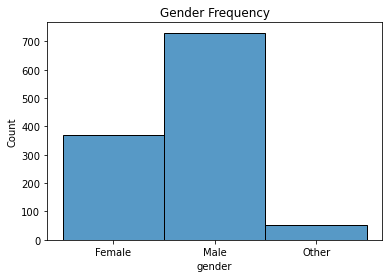

In [13]:
sns.histplot(df.gender).set_title('Gender Frequency')

Text(0.5, 1.0, 'Age Frequency')

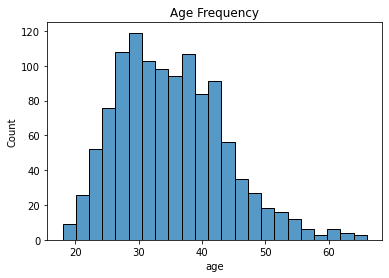

In [14]:
sns.histplot(df.age).set_title('Age Frequency')

Text(0.5, 1.0, 'Current Disorder')

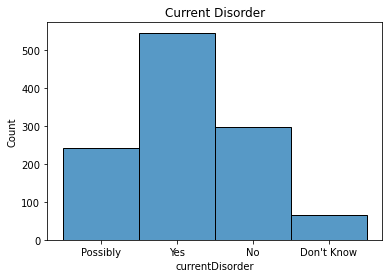

In [15]:
sns.histplot(not_null.currentDisorder, discrete=True).set_title('Current Disorder')

Text(0.5, 1.0, 'Sought Treatment for Health')

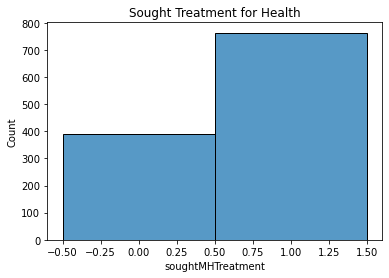

In [16]:
sns.histplot(df.soughtMHTreatment, discrete=True).set_title('Sought Treatment for Health')

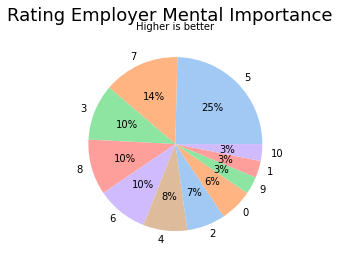

In [17]:
#define data
data = df['MHImportance'].value_counts()

#define Seaborn color palette to use
colors = sns.color_palette('pastel', n_colors=6)

#create pie chart
plt.pie(data, labels=data.index, colors=colors, autopct='%.0f%%')
plt.suptitle('Rating Employer Mental Importance', fontsize=18)
plt.title('Higher is better', fontsize=10)
plt.show()

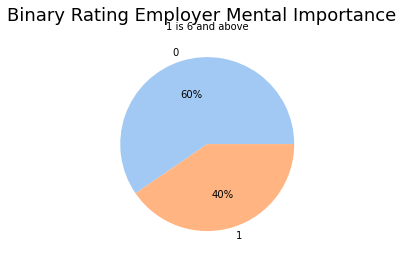

In [18]:
#define data
data = df['MHImportanceBinary'].value_counts()

#define Seaborn color palette to use
colors = sns.color_palette('pastel', n_colors=6)

#create pie chart
plt.pie(data, labels=data.index, colors=colors, autopct='%.0f%%')
plt.suptitle('Binary Rating Employer Mental Importance', fontsize=18)
plt.title('1 is 6 and above', fontsize=10)
plt.show()

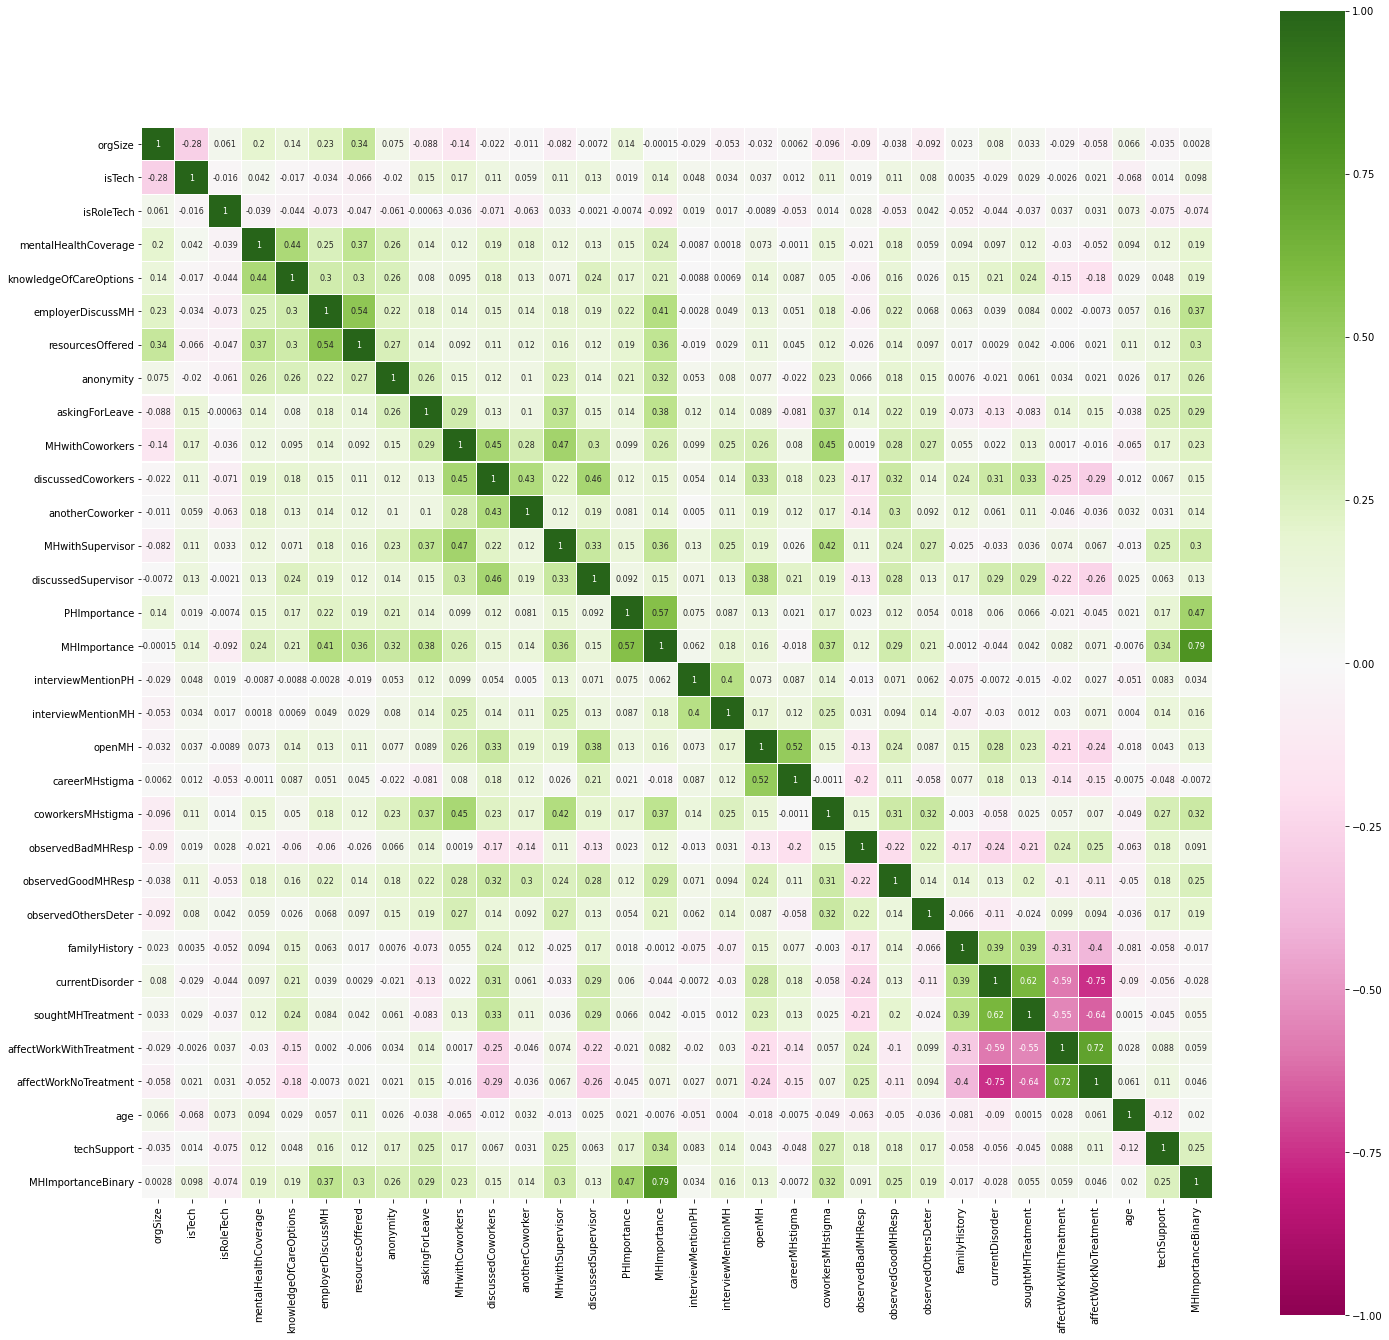

In [19]:
df_corr = df.corr()
plt.figure(figsize=(24, 24))

sns.heatmap(df_corr, 
            cmap='PiYG', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);     

In [20]:
df_corr_binary = df_corr["MHImportanceBinary"]
golden_features_list = df_corr_binary[abs(df_corr_binary) > 0.05].sort_values(ascending=False).drop(['MHImportanceBinary','MHImportance'])
print("There is {} strongly correlated values with MHImportanceBinary:\n{}".format(len(golden_features_list), golden_features_list))

There is 23 strongly correlated values with MHImportanceBinary:
PHImportance               0.469156
employerDiscussMH          0.368756
coworkersMHstigma          0.317764
MHwithSupervisor           0.298711
resourcesOffered           0.298647
askingForLeave             0.292778
anonymity                  0.261386
observedGoodMHResp         0.252055
techSupport                0.249054
MHwithCoworkers            0.227641
observedOthersDeter        0.191512
knowledgeOfCareOptions     0.191200
mentalHealthCoverage       0.187778
interviewMentionMH         0.155661
discussedCoworkers         0.154107
anotherCoworker            0.141288
openMH                     0.132822
discussedSupervisor        0.132653
isTech                     0.098484
observedBadMHResp          0.091433
affectWorkWithTreatment    0.058712
soughtMHTreatment          0.054628
isRoleTech                -0.074191
Name: MHImportanceBinary, dtype: float64


## Predicting preceived Mental Health importance 

In [22]:
#Imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [23]:
y = df['MHImportanceBinary']
X = pd.get_dummies(df.drop(['MHImportanceBinary','MHImportance'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

print("Features:", X_train.shape[1])
print("Training Observations: ", X_train.shape[0])
print("Testing Observations: ", X_test.shape[0])

Features: 73
Training Observations:  922
Testing Observations:  231


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
437,1.250918,0.050810,0.076517,5.362187e-03,551,35,"{'n_estimators': 551, 'max_depth': 35}",0.787879,0.774892,0.856522,0.813043,0.808084,0.031148,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
256,1.234116,0.051365,0.072267,4.024063e-03,551,25,"{'n_estimators': 551, 'max_depth': 25}",0.787879,0.774892,0.856522,0.813043,0.808084,0.031148,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
231,1.322384,0.097752,0.095407,1.734205e-02,551,33,"{'n_estimators': 551, 'max_depth': 33}",0.787879,0.774892,0.856522,0.813043,0.808084,0.031148,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
151,1.348574,0.101270,0.108275,1.537169e-02,551,27,"{'n_estimators': 551, 'max_depth': 27}",0.787879,0.774892,0.856522,0.813043,0.808084,0.031148,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
328,1.208903,0.013397,0.075018,4.061637e-03,551,None,"{'n_estimators': 551, 'max_depth': None}",0.787879,0.774892,0.856522,0.813043,0.808084,0.031148,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,0.736915,0.049574,0.045760,1.088992e-03,408,1,"{'n_estimators': 408, 'max_depth': 1}",0.649351,0.640693,0.621739,0.634783,0.636641,0.010043,496,0.657019,0.642547,0.627168,0.647399,0.643533,0.010789
44,0.988800,0.023022,0.071149,8.411823e-03,633,1,"{'n_estimators': 633, 'max_depth': 1}",0.640693,0.640693,0.621739,0.639130,0.635564,0.008007,497,0.654124,0.648336,0.630058,0.648844,0.645340,0.009110
5,0.850064,0.062612,0.058762,2.278758e-03,551,1,"{'n_estimators': 551, 'max_depth': 1}",0.640693,0.640693,0.617391,0.639130,0.634477,0.009885,498,0.658466,0.643994,0.628613,0.645954,0.644257,0.010602
235,0.923532,0.028167,0.067773,6.068662e-03,612,1,"{'n_estimators': 612, 'max_depth': 1}",0.636364,0.640693,0.617391,0.639130,0.633395,0.009369,499,0.655572,0.646889,0.628613,0.648844,0.644979,0.009983


Best Parameters = {'n_estimators': 551, 'max_depth': 27}
Best Average CV Score = 0.8080839450404668
Best Parameters Training Score = 1.0
Accuracy =  0.7835497835497836
F1 score =  0.7023809523809524
Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       141
           1       0.76      0.66      0.70        90

    accuracy                           0.78       231
   macro avg       0.78      0.76      0.77       231
weighted avg       0.78      0.78      0.78       231

 1) PHImportance                   0.149447
 2) coworkersMHstigma              0.062697
 3) employerDiscussMH              0.060496
 4) age                            0.049647
 5) askingForLeave                 0.047084
 6) MHwithSupervisor               0.038139
 7) techSupport                    0.036449
 8) resourcesOffered               0.033813
 9) orgSize                        0.029838
10) observedGoodMHResp             0.028217
11) anonymity            

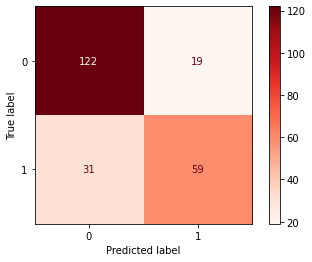

In [24]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(1, 1000, 50)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)

# Maximum depth in tree
rf_max_depth = [int(x) for x in np.linspace(1, 40, 20)]
# Add the default as a possible value
rf_max_depth.append(None)

rf_base = RandomForestClassifier(random_state=0)

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth}
# Create the random search Random Forest
rf_search = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, n_iter=500,
                               cv = 4, n_jobs = -1, return_train_score=True, random_state=0)

# Fit the random search model
rf_search.fit(X_train, y_train)

#Results 
results = pd.DataFrame(rf_search.cv_results_).sort_values(by='rank_test_score')
display(results)

# View the best parameters from the random search
print("Best Parameters =", rf_search.best_params_)
print("Best Average CV Score =", rf_search.best_score_)
print("Best Parameters Training Score =", results.mean_train_score.values[0])

predy = rf_search.predict(X_test)

# Model evaluation
print('Accuracy = ', accuracy_score(y_test, predy))
print('F1 score = ', f1_score(y_test, predy))
ConfusionMatrixDisplay.from_predictions(y_test, predy, cmap='Reds')
print('Report:\n', classification_report(y_test, predy))


feat_labels = X_train.columns

val_list = rf_search.best_estimator_.feature_importances_
idx_list = np.argsort(val_list)[::-1]

iterations = rf_search.best_params_['max_depth']
if (iterations == None):
    iterations = X_train.shape[1]
for f in range(iterations):
    print("%2d) %-*s %f" % (f+1,30,
                            feat_labels[idx_list[f]],
                           val_list[idx_list[f]]))

C:\Users\bazin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 572 is smaller than n_iter=1000. Running 572 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
156,0.205065,0.002380,0.014504,0.000500,100,11,"{'n_estimators': 100, 'max_depth': 11}",0.800866,0.779221,0.839130,0.817391,0.809152,0.021972,1,0.998553,1.000000,1.000000,1.000000,0.999638,0.000627
215,0.506862,0.017615,0.039510,0.008960,228,14,"{'n_estimators': 228, 'max_depth': 14}",0.792208,0.766234,0.834783,0.826087,0.804828,0.027377,2,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
77,1.205333,0.048693,0.114413,0.035895,559,5,"{'n_estimators': 559, 'max_depth': 5}",0.796537,0.774892,0.856522,0.791304,0.804814,0.030903,3,0.876990,0.874096,0.859827,0.865607,0.869130,0.006808
165,0.574878,0.023030,0.038258,0.003270,265,11,"{'n_estimators': 265, 'max_depth': 11}",0.787879,0.766234,0.839130,0.821739,0.803746,0.028437,4,1.000000,1.000000,0.998555,1.000000,0.999639,0.000626
99,2.026563,0.110914,0.118277,0.004868,963,5,"{'n_estimators': 963, 'max_depth': 5}",0.792208,0.770563,0.852174,0.800000,0.803736,0.029973,5,0.874096,0.878437,0.861272,0.868497,0.870575,0.006424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,0.555375,0.021769,0.040759,0.001785,338,2,"{'n_estimators': 338, 'max_depth': 2}",0.757576,0.731602,0.786957,0.756522,0.758164,0.019606,568,0.801737,0.806078,0.778902,0.787572,0.793572,0.010889
22,0.847213,0.032247,0.062668,0.005739,504,2,"{'n_estimators': 504, 'max_depth': 2}",0.761905,0.731602,0.782609,0.756522,0.758159,0.018164,569,0.798842,0.801737,0.777457,0.787572,0.791402,0.009635
5,0.387836,0.037125,0.026506,0.001658,191,2,"{'n_estimators': 191, 'max_depth': 2}",0.744589,0.731602,0.791304,0.760870,0.757091,0.022309,570,0.794501,0.806078,0.780347,0.781792,0.790679,0.010458
14,0.581379,0.021838,0.041510,0.002061,357,2,"{'n_estimators': 357, 'max_depth': 2}",0.757576,0.727273,0.782609,0.760870,0.757082,0.019715,571,0.801737,0.804631,0.780347,0.784682,0.792849,0.010498


Best Parameters: {'n_estimators': 100, 'max_depth': 11}
Best Average CV Score = 0.8091520798042539
Best Parameters Training Score = 0.7910401487330919
Accuracy =  0.7532467532467533
F1 score =  0.6779661016949153
Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       141
           1       0.69      0.67      0.68        90

    accuracy                           0.75       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.75      0.75      0.75       231

 1) PHImportance                   0.201972
 2) coworkersMHstigma              0.093063
 3) employerDiscussMH              0.081921
 4) askingForLeave                 0.066470
 5) techSupport                    0.052188
 6) MHwithSupervisor               0.050660
 7) observedGoodMHResp             0.042841
 8) affectWorkWithTreatment        0.040160
 9) resourcesOffered               0.038466
10) MHwithCoworkers                0.035176
11) observe

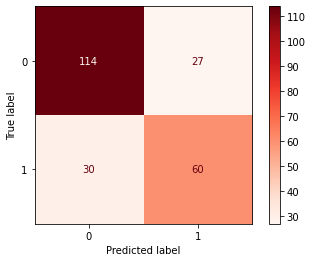

In [25]:
# Using a selected set of features using correlation 
# Not in report
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(100, 1000, 50)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(2, 30, 10)]
# Add the default as a possible value
rf_max_depth.append(None)

rf_base = RandomForestClassifier(random_state=0)

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth}
# Create the random search Random Forest
rf_search = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, n_iter=1000, 
                               cv = 4, n_jobs = -1, return_train_score=True, random_state=0)

# Fit the random search model
rf_search.fit(X_train[golden_features_list.index], y_train)

#Results 
results = pd.DataFrame(rf_search.cv_results_).sort_values(by='rank_test_score')
display(results)

# View the best parameters from the random search
print("Best Parameters:", rf_search.best_params_)
print("Best Average CV Score =", rf_search.best_score_)
print("Best Parameters Training Score =", results.mean_train_score.values[0])

predy = rf_search.predict(X_test[golden_features_list.index])


# Model evaluation
print('Accuracy = ', accuracy_score(y_test, predy))
print('F1 score = ', f1_score(y_test, predy))
ConfusionMatrixDisplay.from_predictions(y_test, predy, cmap='Reds')
print('Report:\n', classification_report(y_test, predy))

feat_labels = X[golden_features_list.index].columns

val_list = rf_search.best_estimator_.feature_importances_
idx_list = np.argsort(val_list)[::-1]

iterations = rf_search.best_params_['max_depth']
if (iterations == None):
    iterations = X_train.shape[1]
for f in range(iterations):
    print("%2d) %-*s %f" % (f+1,30,
                            feat_labels[idx_list[f]],
                           val_list[idx_list[f]]))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
18,0.009504,0.000864,0.004749,0.003030,0.0,entropy,5,"{'ccp_alpha': 0.0, 'criterion': 'entropy', 'ma...",0.731602,0.740260,...,0.773913,0.761444,0.027301,1,0.843705,0.861071,0.822254,0.820809,0.836960,0.016613
1,0.012503,0.002061,0.003251,0.000831,0.0,gini,3,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.722944,0.735931,...,0.782609,0.758197,0.029286,2,0.800289,0.800289,0.780347,0.774566,0.788873,0.011598
2,0.009000,0.001871,0.003251,0.001091,0.0,gini,5,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.709957,0.709957,...,0.795652,0.754978,0.045126,3,0.862518,0.876990,0.855491,0.830925,0.856481,0.016667
3,0.009001,0.000706,0.003002,0.001225,0.0,gini,7,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.718615,0.714286,...,0.760870,0.747356,0.033297,4,0.924747,0.936324,0.910405,0.911850,0.920831,0.010544
17,0.005751,0.000433,0.002502,0.000500,0.0,entropy,3,"{'ccp_alpha': 0.0, 'criterion': 'entropy', 'ma...",0.701299,0.705628,...,0.778261,0.745210,0.042225,5,0.791606,0.810420,0.744220,0.754335,0.775145,0.026948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.009751,0.000432,0.007253,0.008526,0.277778,entropy,17,"{'ccp_alpha': 0.2777777777777778, 'criterion':...",0.593074,0.593074,...,0.591304,0.592189,0.000885,113,0.591896,0.591896,0.592486,0.592486,0.592191,0.000295
185,0.011002,0.000997,0.002251,0.000433,0.277778,entropy,19,"{'ccp_alpha': 0.2777777777777778, 'criterion':...",0.593074,0.593074,...,0.591304,0.592189,0.000885,113,0.591896,0.591896,0.592486,0.592486,0.592191,0.000295
186,0.013002,0.002124,0.002251,0.000434,0.277778,entropy,21,"{'ccp_alpha': 0.2777777777777778, 'criterion':...",0.593074,0.593074,...,0.591304,0.592189,0.000885,113,0.591896,0.591896,0.592486,0.592486,0.592191,0.000295
214,0.011503,0.002693,0.002751,0.000433,0.333333,entropy,13,"{'ccp_alpha': 0.3333333333333333, 'criterion':...",0.593074,0.593074,...,0.591304,0.592189,0.000885,113,0.591896,0.591896,0.592486,0.592486,0.592191,0.000295


Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 5}
Best Average CV Score = 0.7614436288349332
Best Parameters Training Score = 0.836959817806145
Accuracy =  0.7445887445887446
F1 score =  0.681081081081081
Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.79       141
           1       0.66      0.70      0.68        90

    accuracy                           0.74       231
   macro avg       0.73      0.74      0.73       231
weighted avg       0.75      0.74      0.75       231

 1) PHImportance                   0.429421
 2) employerDiscussMH              0.133638
 3) askingForLeave                 0.094083
 4) MHwithSupervisor               0.070449
 5) coworkersMHstigma              0.040979
 6) age                            0.037474
 7) interviewMentionPH             0.033563
 8) observedGoodMHResp             0.029314
 9) gender_Male                    0.022723
10) anotherCoworker                0.

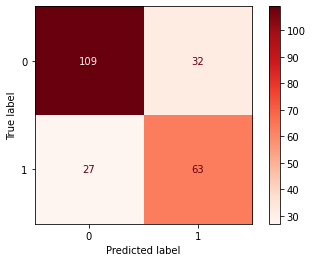

In [43]:
# Criterion
dt_criterion = ["gini", "entropy"]

# Maximum depth in tree
dt_max_depth = [int(x) for x in np.linspace(1, 30, 15)]
# Add the default as a possible value
dt_max_depth.append(None)

dt_alpha = [x for x in np.linspace(0, .5, 10)]
dt_base = DecisionTreeClassifier(random_state=0)

# Create the grid
dt_grid = {'criterion':dt_criterion, 'max_depth': dt_max_depth, 'ccp_alpha':dt_alpha}
# Create the search for decision tree
dt_search = GridSearchCV(estimator = dt_base, param_grid = dt_grid, 
                               cv = 4, n_jobs = -1, return_train_score=True)
# Fit the random search model
dt_search.fit(X_train, y_train)

#Results 
results = pd.DataFrame(dt_search.cv_results_).sort_values(by='rank_test_score')
display(results)

# View the best parameters from the search
print("Best Parameters:", dt_search.best_params_)
print("Best Average CV Score =", dt_search.best_score_)
print("Best Parameters Training Score =", results.mean_train_score.values[0])

predy = dt_search.predict(X_test)


# Model evaluation
print('Accuracy = ', accuracy_score(y_test, predy))
print('F1 score = ', f1_score(y_test, predy))
ConfusionMatrixDisplay.from_predictions(y_test, predy, cmap='Reds')
print('Report:\n', classification_report(y_test, predy))

feat_labels = X_train.columns

val_list = dt_search.best_estimator_.feature_importances_
idx_list = np.argsort(val_list)[::-1]

iterations = rf_search.best_params_['max_depth']
if (iterations == None):
    iterations = X_train.shape[1]
for f in range(iterations):
    print("%2d) %-*s %f" % (f+1,30,
                            feat_labels[idx_list[f]],
                           val_list[idx_list[f]]))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn_clf__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
36,0.008750,0.000828,0.018947,0.002040,37,{'knn_clf__n_neighbors': 37},0.718615,0.757576,0.730435,0.743478,0.737526,0.014537,1,0.764110,0.755427,0.745665,0.741329,0.751633,0.008830
44,0.011752,0.003897,0.018253,0.000433,45,{'knn_clf__n_neighbors': 45},0.727273,0.744589,0.730435,0.743478,0.736444,0.007682,2,0.759768,0.762663,0.744220,0.739884,0.751634,0.009757
38,0.009253,0.002387,0.019753,0.001920,39,{'knn_clf__n_neighbors': 39},0.735931,0.748918,0.717391,0.743478,0.736430,0.011920,3,0.762663,0.749638,0.738439,0.745665,0.749101,0.008799
42,0.011003,0.002122,0.018682,0.001470,43,{'knn_clf__n_neighbors': 43},0.735931,0.740260,0.730435,0.734783,0.735352,0.003497,4,0.752533,0.753980,0.751445,0.739884,0.749460,0.005601
48,0.011002,0.001228,0.019252,0.002774,49,{'knn_clf__n_neighbors': 49},0.714286,0.748918,0.739130,0.730435,0.733192,0.012724,5,0.758321,0.758321,0.745665,0.744220,0.751632,0.006709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.016907,0.012208,0.028178,0.006504,5,{'knn_clf__n_neighbors': 5},0.640693,0.683983,0.643478,0.708696,0.669212,0.028516,96,0.810420,0.788712,0.806358,0.781792,0.796820,0.011911
3,0.009938,0.002796,0.023000,0.011598,4,{'knn_clf__n_neighbors': 4},0.653680,0.649351,0.634783,0.682609,0.655105,0.017354,97,0.793054,0.772793,0.799133,0.770231,0.783803,0.012510
2,0.010503,0.002872,0.026299,0.018202,3,{'knn_clf__n_neighbors': 3},0.649351,0.645022,0.617391,0.686957,0.649680,0.024768,98,0.842258,0.821997,0.845376,0.817919,0.831887,0.012067
1,0.010253,0.003418,0.028257,0.017925,2,{'knn_clf__n_neighbors': 2},0.610390,0.692641,0.600000,0.652174,0.638801,0.036709,99,0.823444,0.798842,0.823699,0.803468,0.812364,0.011327


Best Parameters: {'knn_clf__n_neighbors': 37}
Best Average CV Score = 0.7375258799171843
Best Parameters Training Score = 0.7516327806730632
Accuracy =  0.7402597402597403
F1 score =  0.7114423717521652
Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.80       141
           1       0.72      0.54      0.62        90

    accuracy                           0.74       231
   macro avg       0.73      0.70      0.71       231
weighted avg       0.74      0.74      0.73       231



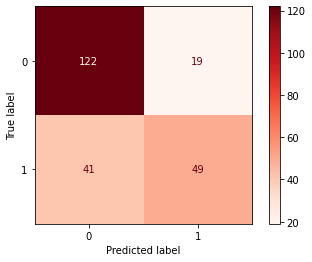

In [44]:
# Maximum number of neighbors
kn_n_neighbors = [int(x) for x in np.linspace(1, 100, 100)]

# Scaling before
kn_base = Pipeline([
        ("scaler", StandardScaler()),
        ("knn_clf", KNeighborsClassifier())])

# Create the grid
kn_grid = {'knn_clf__n_neighbors': kn_n_neighbors}
# Create the search 
kn_search = GridSearchCV(estimator = kn_base, param_grid = kn_grid, 
                               cv = 4, n_jobs = -1, scoring='accuracy', return_train_score=True)

kn_search.fit(X_train, y_train)

#Results 
results = pd.DataFrame(kn_search.cv_results_).sort_values(by='rank_test_score')
display(results)

# View the best parameters from the search
print("Best Parameters:", kn_search.best_params_)
print("Best Average CV Score =", kn_search.best_score_)
print("Best Parameters Training Score =", results.mean_train_score.values[0])

predy = kn_search.predict(X_test)

# Model evaluation
print('Accuracy = ', accuracy_score(y_test, predy))
print('F1 score = ', f1_score(y_test, predy, average='macro'))
ConfusionMatrixDisplay.from_predictions(y_test, predy, cmap='Reds')
print('Report:\n', classification_report(y_test, predy))

In [28]:
# From resources 
from sklearn.base import clone
from itertools import combinations


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

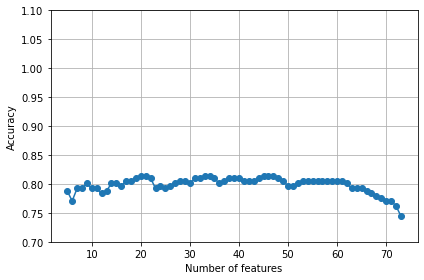

In [29]:
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=kn_search.best_params_['knn_clf__n_neighbors'])

# selecting features
sbs = SBS(knn, k_features=5, test_size=0.2, random_state=0)
sbs.fit(scaler.fit_transform(X), y)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm_clf__C,param_svm_clf__degree,param_svm_clf__kernel,params,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.170557,0.036230,0.007177,0.000770,1.0,3,linear,"{'svm_clf__C': 1.0, 'svm_clf__degree': 3, 'svm...",0.796537,0.787879,...,0.786957,0.789582,0.004033,1,0.837916,0.836469,0.823699,0.830925,0.832252,0.005585
4,0.150784,0.032942,0.007923,0.002382,1.0,4,linear,"{'svm_clf__C': 1.0, 'svm_clf__degree': 4, 'svm...",0.796537,0.787879,...,0.786957,0.789582,0.004033,1,0.837916,0.836469,0.823699,0.830925,0.832252,0.005585
8,0.144281,0.040779,0.007752,0.001921,1.0,5,linear,"{'svm_clf__C': 1.0, 'svm_clf__degree': 5, 'svm...",0.796537,0.787879,...,0.786957,0.789582,0.004033,1,0.837916,0.836469,0.823699,0.830925,0.832252,0.005585
12,0.135541,0.031627,0.006752,0.000433,1.0,9,linear,"{'svm_clf__C': 1.0, 'svm_clf__degree': 9, 'svm...",0.796537,0.787879,...,0.786957,0.789582,0.004033,1,0.837916,0.836469,0.823699,0.830925,0.832252,0.005585
16,0.131750,0.035807,0.006752,0.000433,1.0,10,linear,"{'svm_clf__C': 1.0, 'svm_clf__degree': 10, 'sv...",0.796537,0.787879,...,0.786957,0.789582,0.004033,1,0.837916,0.836469,0.823699,0.830925,0.832252,0.005585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,0.057763,0.003113,0.014753,0.003031,6.444444,10,poly,"{'svm_clf__C': 6.444444444444445, 'svm_clf__de...",0.593074,0.597403,...,0.591304,0.594358,0.002341,193,0.761216,0.745297,0.754335,0.757225,0.754518,0.005858
97,0.053522,0.006796,0.015382,0.003892,22.777778,10,poly,"{'svm_clf__C': 22.77777777777778, 'svm_clf__de...",0.593074,0.597403,...,0.586957,0.593271,0.003958,197,0.797395,0.806078,0.800578,0.807803,0.802964,0.004178
57,0.058513,0.005501,0.018005,0.005959,11.888889,10,poly,"{'svm_clf__C': 11.88888888888889, 'svm_clf__de...",0.593074,0.597403,...,0.586957,0.593271,0.003958,197,0.775687,0.769899,0.780347,0.778902,0.776209,0.004014
13,0.054012,0.003242,0.012253,0.000433,1.0,9,poly,"{'svm_clf__C': 1.0, 'svm_clf__degree': 9, 'svm...",0.593074,0.597403,...,0.586957,0.593271,0.003958,197,0.707670,0.700434,0.710983,0.708092,0.706795,0.003887


Best Parameters: {'svm_clf__C': 1.0, 'svm_clf__degree': 3, 'svm_clf__kernel': 'linear'}
Best Average CV Score = 0.7895821569734613
Best Parameters Training Score = 0.8322523067013543
Accuracy =  0.7532467532467533
F1 score =  0.6850828729281768
Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80       141
           1       0.68      0.69      0.69        90

    accuracy                           0.75       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.75      0.75      0.75       231



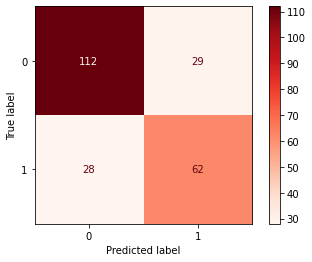

In [45]:
# regulariztion factor
C = [x for x in np.linspace(1, 50, 10)]

# kernals
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# degrees
degrees =[3,4,5,9,10]

svc_base = Pipeline([
        ("scaler", scaler),
        ("svm_clf", SVC(random_state=0))])

# Create the grid

svc_grid = {'svm_clf__C':C, 'svm_clf__kernel': kernels, 'svm_clf__degree': degrees}
# Create the search 
svc_search = GridSearchCV(estimator = svc_base, param_grid = svc_grid, 
                               cv = 4, n_jobs = -1, return_train_score=True)

svc_search.fit(X_train, y_train)

#Results 
results = pd.DataFrame(svc_search.cv_results_).sort_values(by='rank_test_score')
display(results)

# View the best parameters from the search
print("Best Parameters:", svc_search.best_params_)
print("Best Average CV Score =", svc_search.best_score_)
print("Best Parameters Training Score =", results.mean_train_score.values[0])

predy = svc_search.predict(X_test)

# Model evaluation
print('Accuracy = ', accuracy_score(y_test, predy))
print('F1 score = ', f1_score(y_test, predy))
ConfusionMatrixDisplay.from_predictions(y_test, predy, cmap='Reds')
print('Report:\n', classification_report(y_test, predy))

## Things to look into next

In [31]:
# Things to look into:
#     feature selection
#     polynomial_features
#     dimensionality reduction
#     bias
#     SMOTE for other imbalanced target variable

In [35]:
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

sm = BorderlineSMOTE(k_neighbors=kn_search.best_params_['knn_clf__n_neighbors'], random_state=0)
X_res, y_res = sm.fit_resample(X_train.to_numpy(), y_train)

In [36]:
dt_criterion = ["gini", "entropy"]

# Maximum depth in tree
dt_max_depth = [int(x) for x in np.linspace(2, 30, 15)]
# Add the default as a possible value
dt_max_depth.append(None)

dt_alpha = [x for x in np.linspace(0, .5, 10)]
dt_base = DecisionTreeClassifier()

# Create the grid
dt_grid = {'criterion':dt_criterion, 'max_depth': dt_max_depth, 'ccp_alpha':dt_alpha}
# Create the search for decision tree
dt_search = GridSearchCV(estimator = dt_base, param_grid = dt_grid, 
                               cv = 5, n_jobs = -1)
# Fit the random search model
dt_search.fit(X_res, y_res)

dt_search.predict(X_test)

# Model evaluation
print('Accuracy = ', accuracy_score(y_test, predy))
print('Confusion:\n', confusion_matrix(y_test, predy))
print('F1 score = ', f1_score(y_test, predy))
print('Report:\n', classification_report(y_test, predy))

Accuracy =  0.7532467532467533
Confusion:
 [[112  29]
 [ 28  62]]
F1 score =  0.6850828729281768
Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80       141
           1       0.68      0.69      0.69        90

    accuracy                           0.75       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.75      0.75      0.75       231



C:\Users\bazin\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
